In [1]:
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from scipy.sparse import csr_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())



In [3]:
# load feature importance
fi = pd.read_csv('../results/xgb_feature_importances_v1_top500.csv', index_col=0)
products = pd.read_csv('../data/products.csv', index_col=0, usecols=['product_id', 'product_name'])

# build product name dictionary for product_ids in strings
products_dict_string = {}
for k, v in products.to_dict()['product_name'].items():
    products_dict_string[str(k)] = v

fi = fi.rename(columns=products_dict_string, index=products.to_dict()['product_name'])
fi.head()

,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Whole Milk,Organic Raspberries,...,order_hod_15,order_hod_16,order_hod_17,order_hod_18,order_hod_19,order_hod_20,order_hod_21,order_hod_22,order_hod_23,Banana
Banana,16429.526711,1279.071116,517.772529,39.502174,2750.613134,775.537591,1600.779739,61.527677,804.173961,36.919135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bag of Organic Bananas,NaN,2301.037867,1715.161014,4171.241089,27.711317,18.298088,29.048433,24.578167,770.728439,1822.199426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22385.882321
Organic Strawberries,2576.305969,NaN,1995.664821,2642.691564,1013.659842,31.463527,2321.034563,166.930545,1994.481109,5175.236566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1543.809114
Organic Baby Spinach,1699.331320,2290.482298,NaN,3773.820365,5673.249576,1449.552438,27.865870,346.613926,432.487979,17.776998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499.537555
Organic Hass Avocado,9399.550122,4647.737054,3132.413388,NaN,3506.243967,134.378344,178.815864,2337.994997,45.859021,2778.636262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.096809


In [5]:
# normalize values
arr = fi.fillna(0).values
arr = normalize(arr)
fi_norm = pd.DataFrame(arr, index=fi.index, columns=fi.columns)
display(fi_norm.head())
fi_norm.to_csv('../results/xgb_feature_importances_v1_top500_norm_all.csv')

,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Whole Milk,Organic Raspberries,...,order_hod_15,order_hod_16,order_hod_17,order_hod_18,order_hod_19,order_hod_20,order_hod_21,order_hod_22,order_hod_23,Banana
Banana,0.145012,0.011289,0.004570,0.000349,0.024278,0.006845,0.014129,0.000543,0.007098,0.000326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bag of Organic Bananas,0.000000,0.020310,0.015139,0.036817,0.000245,0.000162,0.000256,0.000217,0.006803,0.016083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197584
Organic Strawberries,0.022739,0.000000,0.017614,0.023325,0.008947,0.000278,0.020486,0.001473,0.017604,0.045678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013626
Organic Baby Spinach,0.014999,0.020216,0.000000,0.033309,0.050074,0.012794,0.000246,0.003059,0.003817,0.000157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004409
Organic Hass Avocado,0.082963,0.041022,0.027648,0.000000,0.030947,0.001186,0.001578,0.020636,0.000405,0.024525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000654


Text(0, 0.5, 'Normalized Feature Importance')

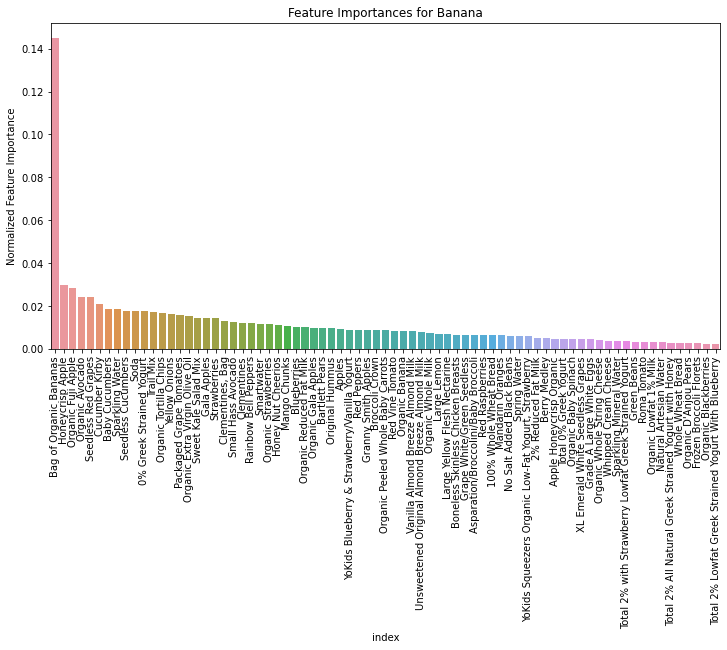

In [6]:
# plot top feature importances

product_of_interest = 'Banana'
num_features = 75

feature_importances = fi_norm.loc[product_of_interest]
feature_importances = feature_importances.sort_values(ascending=False)[:num_features]

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.reset_index(), x='index', y=product_of_interest)
plt.xticks(rotation=90)
plt.title(f"Feature Importances for {product_of_interest}")
plt.ylabel('Normalized Feature Importance')

In [ ]:
fi_norm.loc['Bag of Organic Bananas', 'Organic Kiwi']

In [8]:
[fi_norm == 1]

ValueError: Cannot index with multidimensional key

In [10]:
np.argwhere(arr == 1)

array([[400, 324]], dtype=int64)

In [11]:
fi_norm.iloc[400, 324]

1.0

In [12]:
fi.index.tolist()[400]

'Rainbow Bell Peppers'

In [14]:
fi.columns.tolist()[323]

'2% Reduced Fat DHA Omega-3 Reduced Fat Milk'

(array([2.15924e+05, 2.28400e+04, 1.23830e+04, 6.13600e+03, 3.17000e+03,
        1.94400e+03, 1.18700e+03, 7.08000e+02, 4.30000e+02, 2.47000e+02,
        1.64000e+02, 1.06000e+02, 6.10000e+01, 3.70000e+01, 2.50000e+01,
        1.70000e+01, 9.00000e+00, 1.70000e+01, 1.30000e+01, 7.00000e+00,
        3.00000e+00, 3.00000e+00, 6.00000e+00, 5.00000e+00, 3.00000e+00,
        3.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00,
        3.00000e+00, 5.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00,
        4.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

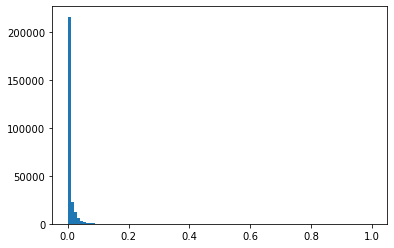

In [18]:
plt.hist(fi_norm.values.flatten(), bins = 100)